In [2]:
!pip install pymc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.1 MB/s eta 0:00:00


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

import pymc as pm
import pytensor
import pytensor.tensor as pt
import numpy as np
import pandas as pd
from scipy import stats as sps

from pytensor.tensor.conv import conv2d

from patients import get_delay_distribution


class GenerativeModel:
    version = "2.0.0"

    def __init__(self, region: str, observed: pd.DataFrame, buffer_days=10):
        """Инициализация модели: обрезаем нули в начале и добавляем буфер"""
        first_index = observed.positive.ne(0).argmax()
        observed = observed.iloc[first_index:]

        new_index = pd.date_range(
            start=observed.index[0] - pd.Timedelta(days=buffer_days),
            end=observed.index[-1],
            freq="D",
        )
        observed = observed.reindex(new_index, fill_value=0)

        self.model = None
        self._trace = None
        self.observed = observed
        self.region = region

    def _get_generation_time_interval(self):
        """Дискретизация распределения интервала генерации (по литературным данным)."""
        mean_si, std_si = 4.7, 2.9
        mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
        sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
        dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

        g_range = np.arange(0, 20)
        gt = pd.Series(dist.cdf(g_range), index=g_range).diff().fillna(0)
        gt /= gt.sum()
        return gt.values

    def _get_convolution_ready_gt(self, len_observed):
        """Создаём матрицу свёртки для ускорения вычислений."""
        gt = self._get_generation_time_interval()
        convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
        for t in range(1, len_observed):
            begin = max(0, t - len(gt) + 1)
            slice_update = gt[1 : t - begin + 1][::-1]
            convolution_ready_gt[t - 1, begin : begin + len(slice_update)] = slice_update
        return pytensor.shared(convolution_ready_gt)

    def build(self):
        """Сборка стохастической модели в PyMC5"""
        p_delay = get_delay_distribution()
        len_observed = len(self.observed)
        convolution_ready_gt = self._get_convolution_ready_gt(len_observed)
        nonzero_days = self.observed.total.gt(0)

        coords = {"date": self.observed.index.values}

        with pm.Model(coords=coords) as self.model:
            log_r_t = pm.GaussianRandomWalk("log_r_t", sigma=0.035, dims="date")

            r_t = pm.Deterministic("r_t", pt.exp(log_r_t), dims="date")

            # начальные условия
            y0 = pt.zeros(len_observed)
            y0 = pt.set_subtensor(y0[0], 1e-3)

            # рекурсивное вычисление
            def step(t, gt, y, r_t):
                return pt.set_subtensor(y[t], pt.sum(r_t * y * gt))

            outputs, _ = pytensor.scan(
                fn=step,
                sequences=[pt.arange(1, len_observed), convolution_ready_gt],
                outputs_info=y0,
                non_sequences=[r_t],
                n_steps=len_observed - 1,
            )

            # регистрируем вычисленные величины в модели
            infections = pm.Deterministic("infections", outputs[-1], dims="date")

            test_adjusted_positive = pm.Deterministic(
                "test_adjusted_positive",
                conv2d(
                    pt.reshape(infections, (1, 1, 1, len_observed)),
                    pt.reshape(p_delay.values, (1, 1, 1, len(p_delay))),
                    border_mode="full",
                )[0, 0, 0, :len_observed],
                dims="date",
            )

            tests = pm.Data("tests", self.observed.total.values, dims="date")
            exposure = pm.Deterministic(
                "exposure",
                pm.math.clip(tests, self.observed.total.max() * 0.1, 1e9),
                dims="date",
            )

            positive = pm.Deterministic(
                "positive", exposure * test_adjusted_positive, dims="date"
            )

            observed_positive = pm.Data(
                "observed_positive", self.observed.positive.values, dims="date"
            )

            pm.NegativeBinomial(
                "likelihood",
                mu=positive[nonzero_days.values],
                alpha=pm.Gamma("alpha", mu=6, sigma=1),
                observed=observed_positive[nonzero_days.values],
            )

        return self.model

    def sample(self, draws=500, tune=500, chains=4, cores=4):
        """Запуск MCMC выборки"""
        if self.model is None:
            self.build()
        with self.model:
            self._trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                target_accept=0.95,
                init="jitter+adapt_diag",
                random_seed=42,
            )
        return self._trace


In [4]:
import pandas as pd

df = pd.read_csv('owid-covid-data.csv')
countries = ["Russia", "Italy", "Germany", "France"]
data = df[df.location.isin(countries)]


def prepare_country_data(df_country):
    df_country = df_country[(df_country.date >= "2020-01-01") & (df_country.date <= "2020-12-01")]
    df_country = df_country[df_country.new_cases > 100]
    df_country = df_country[["date", "new_cases", "new_tests"]].rename(
        columns={"new_cases": "positive", "new_tests": "total"}
    ).fillna(0).set_index("date")
    df_country.index = pd.to_datetime(df_country.index)
    return df_country

country_dfs = {c: prepare_country_data(data[data.location == c]) for c in countries}

In [ ]:
models = {}
traces = {}

print(f"Обучение модели для {"Russia"}")
df_country = country_dfs["Russia"]
model = GenerativeModel(region="Russia", observed=df_country)
trace = model.sample(draws=1000, tune=750)
models["Russia"] = model
traces["Russia"] = trace

Обучение модели для Russia


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

In [ ]:
print(f"Обучение модели для {"Italy"}")
df_country = country_dfs["Italy"]
model = GenerativeModel(region="Italy", observed=df_country)
trace = model.sample(draws=1000, tune=750)
models["Italy"] = model
traces["Italy"] = trace

Обучение модели для Italy


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

In [5]:
print(f"Обучение модели для {"Germany"}")
df_country = country_dfs["Germany"]
model = GenerativeModel(region="Germany", observed=df_country)
trace = model.sample(draws=1000, tune=750)
models["Germany"] = model
traces["Germany"] = trace

Обучение модели для Germany


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

ERROR:pymc.stats.convergence:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


NameError: name 'models' is not defined

In [7]:
models = {}
traces = {}
models["Germany"] = model
traces["Germany"] = trace

In [9]:
print(f"Обучение модели для {"France"}")
df_country = country_dfs["France"]
model = GenerativeModel(region="France", observed=df_country)
trace = model.sample(draws=1000, tune=750)
models["France"] = model
traces["France"] = trace

Обучение модели для France


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

In [ ]:
models = {}
traces = {}

for country in countries:
    print(f"Обучение модели для {country}...")
    df_country = country_dfs[country]
    model = GenerativeModel(region=country, observed=df_country)
    trace = model.sample(draws=1000, tune=750)
    models[country] = model
    traces[country] = trace



Обучение модели для Russia...


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

ValueError: Not enough samples to build a trace.

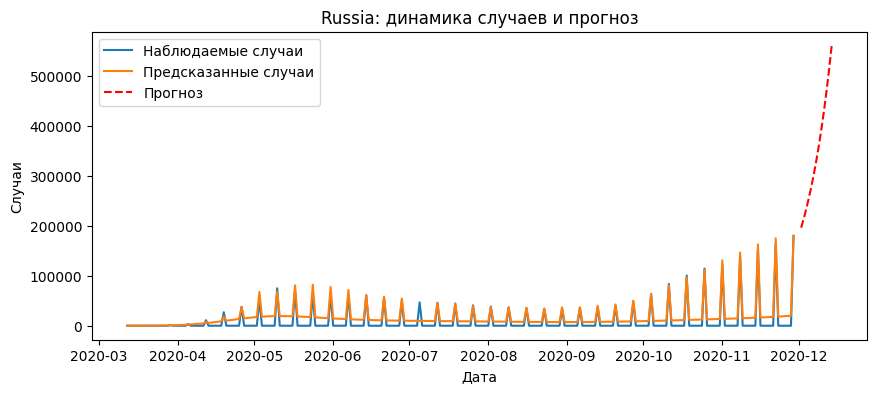

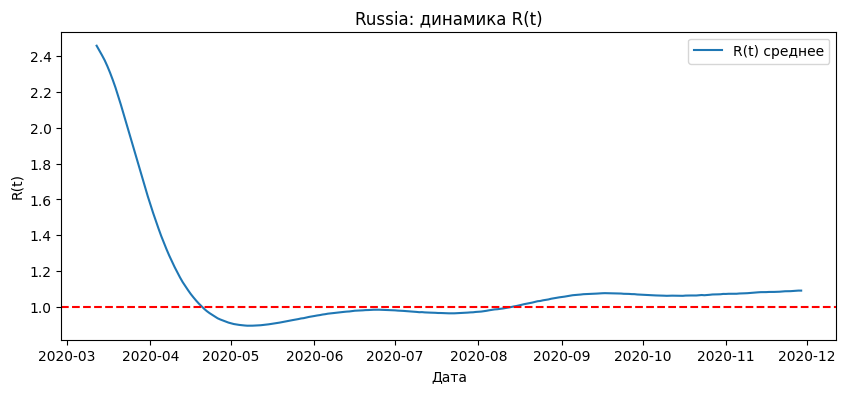

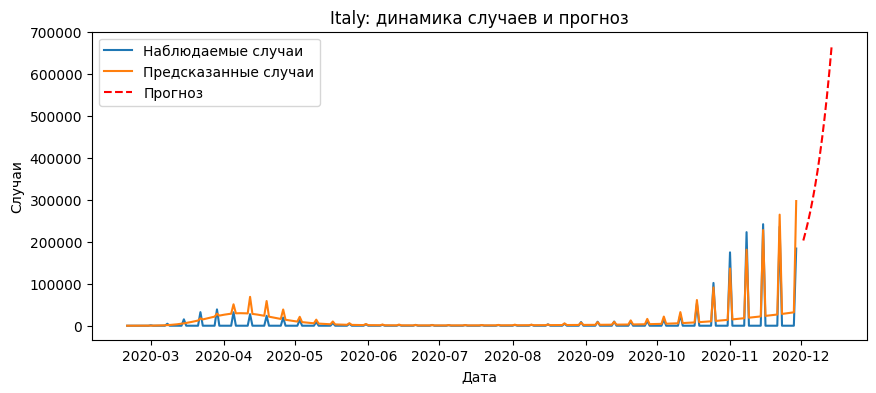

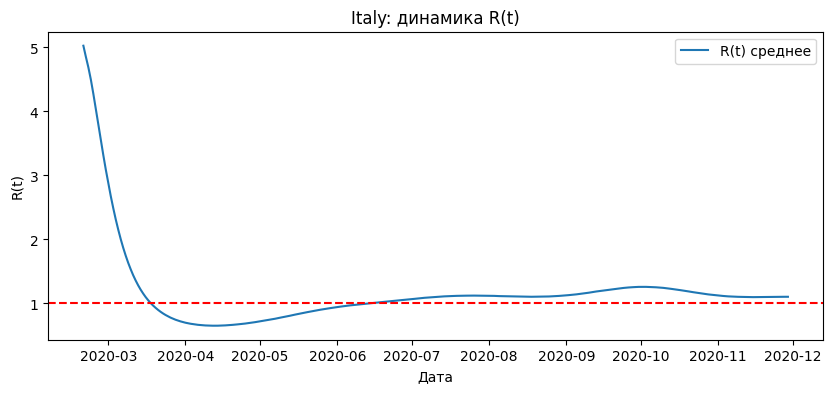

KeyError: 'Germany'

In [ ]:
import matplotlib.pyplot as plt

for country in countries:
    model = models[country]
    trace = traces[country]

    # R(t)
    r_t_samples = trace.posterior["r_t"].stack(draws=("chain","draw")).values
    r_t_mean = r_t_samples.mean(axis=1)

    # Прогноз числа зарегистрированных случаев на 02.12.2020 - 14.12.2020
    future_dates = pd.date_range("2020-12-02", "2020-12-14")

    # Используем последний день наблюдений как старт
    last_infections = model.observed.positive.values[-1]

    # Для простого прогноза можно экстраполировать среднее R(t) последних дней
    r_t_last = r_t_mean[-1]
    predicted_cases = [last_infections * r_t_last ** i for i in range(1, len(future_dates)+1)]

    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, model.observed.positive.values, label="Наблюдаемые случаи")
    plt.plot(model.observed.index, trace.posterior["positive"].mean(dim=["chain","draw"]).values, label="Предсказанные случаи")
    plt.plot(future_dates, predicted_cases, "r--", label="Прогноз")
    plt.title(f"{country}: динамика случаев и прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Случаи")
    plt.legend()
    plt.show()

    # R(t)
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, r_t_mean, label="R(t) среднее")
    plt.title(f"{country}: динамика R(t)")
    plt.xlabel("Дата")
    plt.ylabel("R(t)")
    plt.axhline(1.0, color="r", linestyle="--")
    plt.legend()
    plt.show()


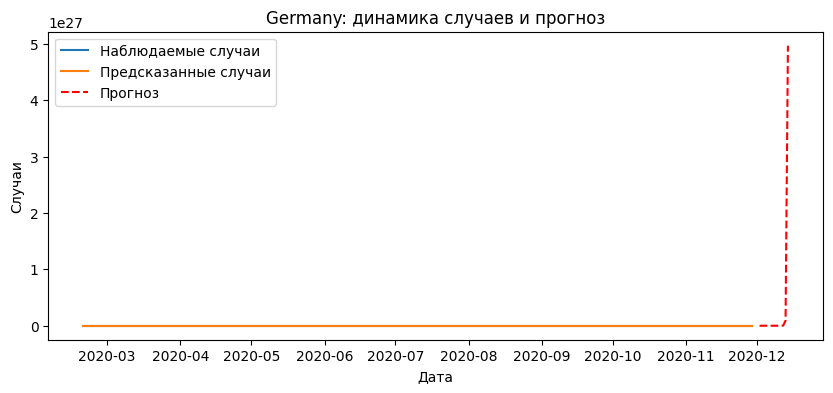

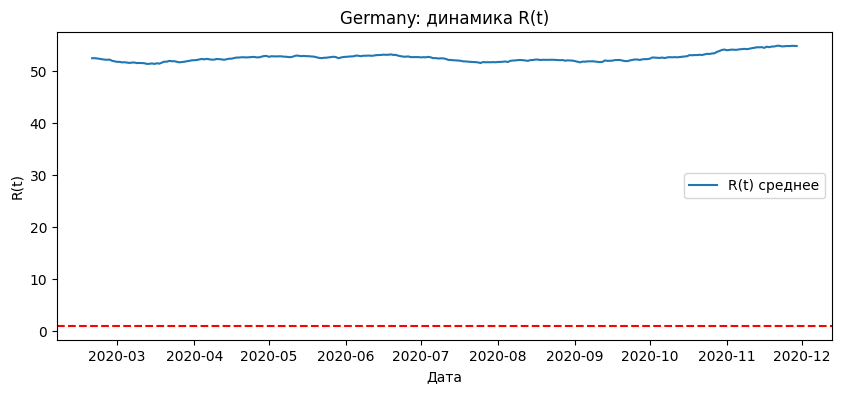

In [8]:
import matplotlib.pyplot as plt

for country in ['Germany']:
    model = models[country]
    trace = traces[country]

    # R(t)
    r_t_samples = trace.posterior["r_t"].stack(draws=("chain","draw")).values
    r_t_mean = r_t_samples.mean(axis=1)

    # Прогноз числа зарегистрированных случаев на 02.12.2020 - 14.12.2020
    future_dates = pd.date_range("2020-12-02", "2020-12-14")

    # Используем последний день наблюдений как старт
    last_infections = model.observed.positive.values[-1]

    # Для простого прогноза можно экстраполировать среднее R(t) последних дней
    r_t_last = r_t_mean[-1]
    predicted_cases = [last_infections * r_t_last ** i for i in range(1, len(future_dates)+1)]

    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, model.observed.positive.values, label="Наблюдаемые случаи")
    plt.plot(model.observed.index, trace.posterior["positive"].mean(dim=["chain","draw"]).values, label="Предсказанные случаи")
    plt.plot(future_dates, predicted_cases, "r--", label="Прогноз")
    plt.title(f"{country}: динамика случаев и прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Случаи")
    plt.legend()
    plt.show()

    # R(t)
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, r_t_mean, label="R(t) среднее")
    plt.title(f"{country}: динамика R(t)")
    plt.xlabel("Дата")
    plt.ylabel("R(t)")
    plt.axhline(1.0, color="r", linestyle="--")
    plt.legend()
    plt.show()


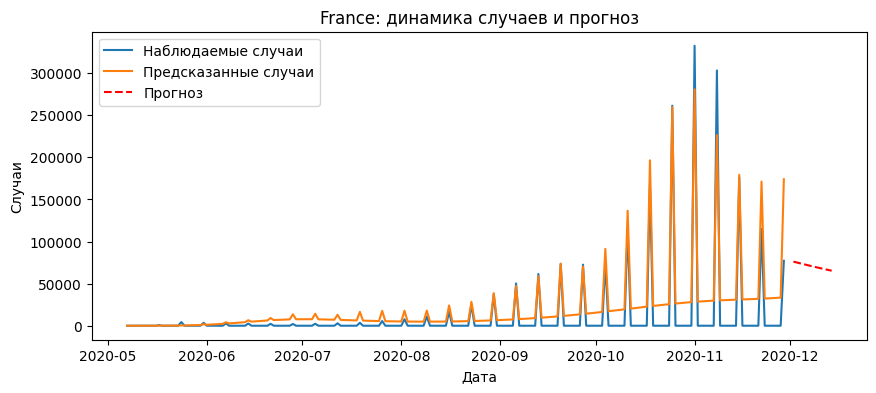

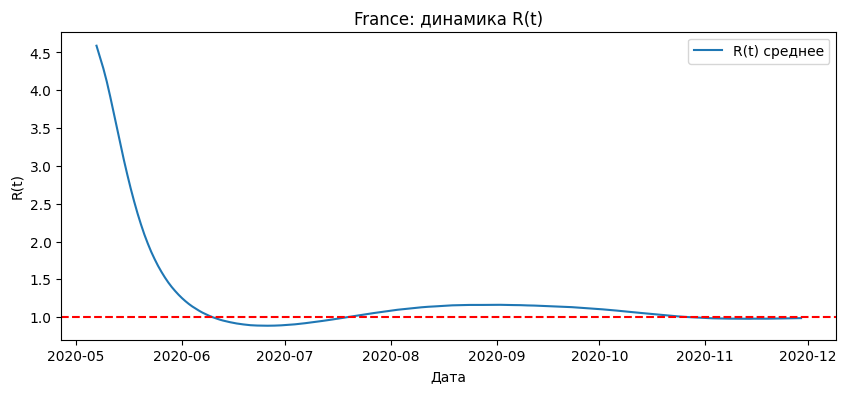

In [10]:
import matplotlib.pyplot as plt

for country in ['France']:
    model = models[country]
    trace = traces[country]

    # R(t)
    r_t_samples = trace.posterior["r_t"].stack(draws=("chain","draw")).values
    r_t_mean = r_t_samples.mean(axis=1)

    # Прогноз числа зарегистрированных случаев на 02.12.2020 - 14.12.2020
    future_dates = pd.date_range("2020-12-02", "2020-12-14")

    # Используем последний день наблюдений как старт
    last_infections = model.observed.positive.values[-1]

    # Для простого прогноза можно экстраполировать среднее R(t) последних дней
    r_t_last = r_t_mean[-1]
    predicted_cases = [last_infections * r_t_last ** i for i in range(1, len(future_dates)+1)]

    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, model.observed.positive.values, label="Наблюдаемые случаи")
    plt.plot(model.observed.index, trace.posterior["positive"].mean(dim=["chain","draw"]).values, label="Предсказанные случаи")
    plt.plot(future_dates, predicted_cases, "r--", label="Прогноз")
    plt.title(f"{country}: динамика случаев и прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Случаи")
    plt.legend()
    plt.show()

    # R(t)
    plt.figure(figsize=(10, 4))
    plt.plot(model.observed.index, r_t_mean, label="R(t) среднее")
    plt.title(f"{country}: динамика R(t)")
    plt.xlabel("Дата")
    plt.ylabel("R(t)")
    plt.axhline(1.0, color="r", linestyle="--")
    plt.legend()
    plt.show()
